# Stereoscope applied to left ventricule data

- Developed by Carlos Talavera-López Ph.D, WSI, edited by Romain Lopez
- Version: 210301

In this notebook, we present the workflow to run Stereoscope within the scvi-tools codebase. We map the adult heart cell atlas data from [Litviňuková et al (2020)](https://www.nature.com/articles/s41586-020-2797-4). This experiment takes around one hour to run on Colab.

You can access the raw count matrices as 'anndata' objects at www.heartcellatlas.org.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [12]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

c:\Users\savbe\Desktop\azizilab_assignment\scvi-tools\scvi-venv\Lib\site-packages\scvi_colab\_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import torch

import scvi
from scvi.external import RNAStereoscope, SpatialStereoscope

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.2.1


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Download single-cell data

Read in expression data. This is a subset of the data you want to map. Here I use a balanced subset of cells from the left ventricle (~ 50K). You can create your own subset according to what you are interested in.

In [4]:
adata_path = os.path.join(save_dir.name, "adata.h5ad")

sc_adata = sc.read(
    adata_path,
    backup_url="https://ndownloader.figshare.com/files/26153564",
)
sc_adata

  0%|          | 0.00/124M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 35928 × 33538
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    obsm: 'X_pca', 'X_umap'

## Preprocess single-cell data

In [5]:
sc.pp.filter_genes(sc_adata, min_counts=10)
sc_adata

AnnData object with n_obs × n_vars = 35928 × 25145
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

In [6]:
sc_adata.obs["combined"] = [
    sc_adata.obs.loc[i, "cell_source"] + sc_adata.obs.loc[i, "donor"] for i in sc_adata.obs_names
]
sc_adata

AnnData object with n_obs × n_vars = 35928 × 25145
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states', 'combined'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

Remove mitochondrial genes

In [7]:
non_mito_genes_list = [name for name in sc_adata.var_names if not name.startswith("MT-")]
sc_adata = sc_adata[:, non_mito_genes_list]
sc_adata

View of AnnData object with n_obs × n_vars = 35928 × 25132
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states', 'combined'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

Normalize data on a different layer, because Stereoscope works with raw counts. We did not see better results by using all the genes, so for computational purposed we cut here to 7,000 genes.

In [8]:
sc_adata.layers["counts"] = sc_adata.X.copy()
sc.pp.normalize_total(sc_adata, target_sum=1e5)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

C:\Users\savbe\AppData\Local\Temp\ipykernel_14768\60512395.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  sc_adata.layers["counts"] = sc_adata.X.copy()


In [9]:
sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=7000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    span=1,
)

Examine the cell type labels

In [10]:
sc_adata.obs["cell_states"].value_counts()

cell_states
EC5_art        2000
PC3_str        2000
EC2_cap        2000
EC1_cap        2000
vCM1           2000
FB1            2000
SMC1_basic     2000
PC1_vent       2000
vCM2           2000
vCM3           2000
vCM4           2000
FB4            1912
EC3_cap        1712
EC6_ven        1292
DOCK4+MØ1       970
EC4_immune      751
CD4+T_cytox     642
NC1             524
Mast            453
FB3             436
CD8+T_cytox     429
LYVE1+MØ1       394
LYVE1+MØ2       390
CD8+T_tem       368
SMC2_art        323
NK              322
FB2             308
FB5             245
vCM5            235
CD16+Mo         234
Mo_pi           227
NKT             224
LYVE1+MØ3       223
CD4+T_tem       170
DC              143
CD14+Mo         132
Adip1           126
MØ_AgP          116
B_cells         112
NC2             102
DOCK4+MØ2        99
EC8_ln           90
NC4              59
MØ_mod           48
NC3              39
Meso             30
Adip2            15
Adip4            11
Adip3             8
NØ      

## Read in visium data

In [11]:
st_adata = sc.datasets.visium_sge(sample_id="V1_Human_Heart")
st_adata.var_names_make_unique()

c:\Users\savbe\Desktop\azizilab_assignment\scvi-tools\scvi-venv\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\savbe\Desktop\azizilab_assignment\scvi-tools\scvi-venv\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
st_adata.var["mt"] = st_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(st_adata, qc_vars=["mt"], inplace=True)
st_adata

AnnData object with n_obs × n_vars = 4247 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

- Clean up data based on QC values

C:\Users\savbe\AppData\Local\Temp\ipykernel_14768\2459342404.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(st_adata.obs["total_counts"], kde=False, ax=axs[0])
C:\Users\savbe\AppData\Local\Temp\ipykernel_14768\2459342404.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
C:\Users\savbe\Ap

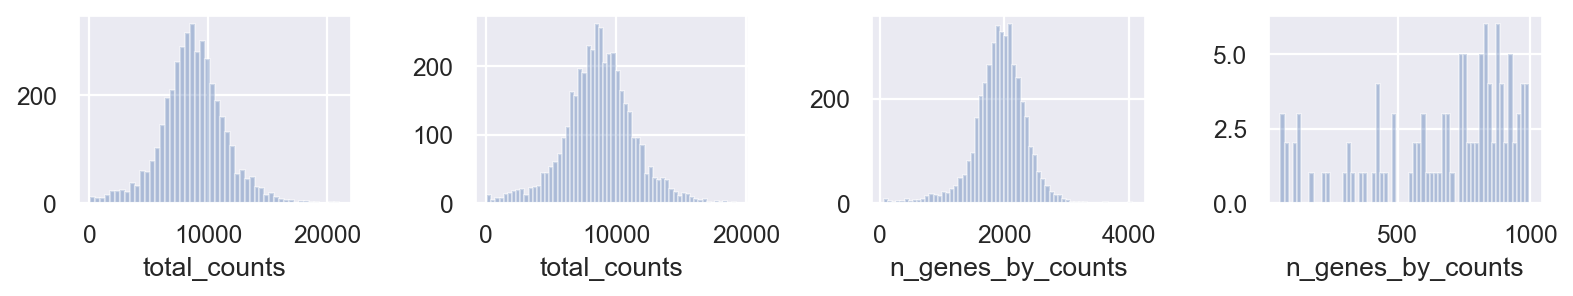

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2))
sns.distplot(st_adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(
    st_adata.obs["total_counts"][st_adata.obs["total_counts"] < 20000],
    kde=False,
    bins=60,
    ax=axs[1],
)
sns.distplot(st_adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(
    st_adata.obs["n_genes_by_counts"][st_adata.obs["n_genes_by_counts"] < 1000],
    kde=False,
    bins=60,
    ax=axs[3],
)
plt.tight_layout()
plt.show()

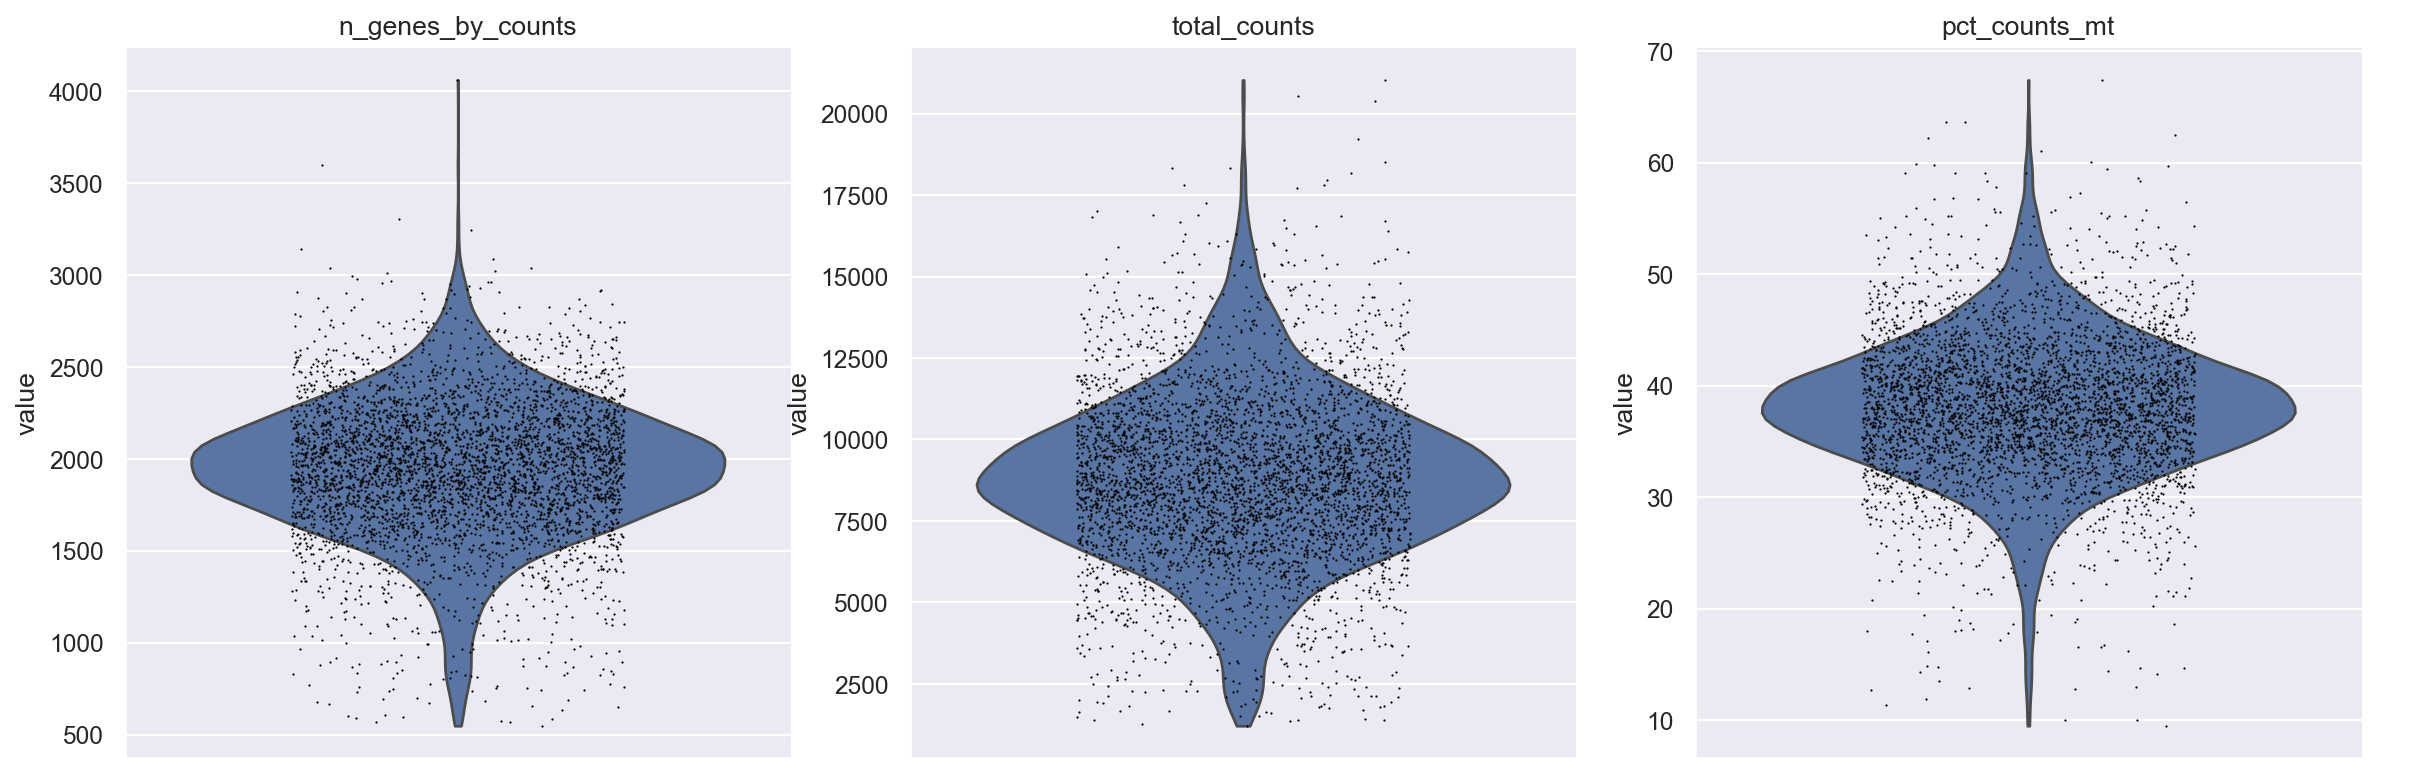

AnnData object with n_obs × n_vars = 4218 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [14]:
sc.pp.filter_cells(st_adata, min_counts=500)
sc.pp.filter_cells(st_adata, min_genes=500)
sc.pl.violin(
    st_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.25,
    multi_panel=True,
)
st_adata

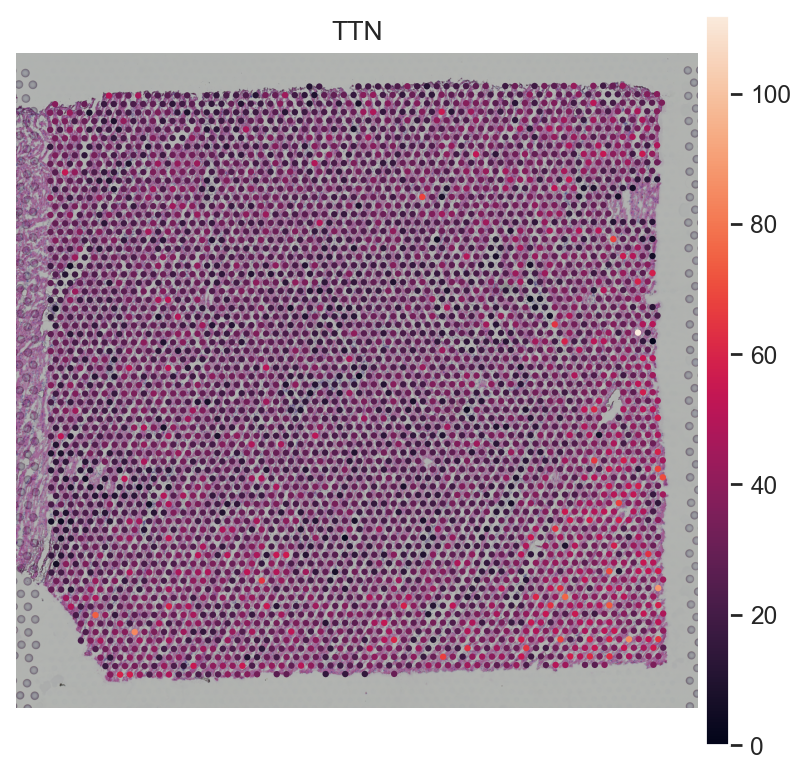

In [15]:
sc.pl.spatial(st_adata, img_key="hires", color=["TTN"])

## Learn cell-type specific gene expression from scRNA-seq data

Filter genes to be the same on the spatial data

In [16]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

Setup the AnnData object

In [17]:
scvi.model.SCVI.setup_anndata(sc_adata, layer="counts", batch_key="combined")

RNAStereoscope.setup_anndata(
    sc_adata, layer="counts", labels_key="cell_states", batch_key="combined"
)
sc_adata.obs

C:\Users\savbe\Desktop\azizilab_assignment\scvi-tools\src\scvi\data\fields\_dataframe_field.py:186: UserWarning: Category 39 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


,age_group,cell_source,cell_type,donor,gender,n_counts,n_genes,percent_mito,percent_ribo,region,sample,scrublet_score,version,cell_states,combined,_scvi_batch,_scvi_labels
AAAGGTACAGAAATTG-1-H0015_LV-0-large,50-55,Harvard-Nuclei,Ventricular_Cardiomyocyte,H5,Female,8912.0,3017,0.000785,0.000898,LV,H0015_LV,0.132150,V3,vCM1,Harvard-NucleiH5,3,48
AAAGTCCCAGAACTTC-1-H0015_LV-0-large,50-55,Harvard-Nuclei,Ventricular_Cardiomyocyte,H5,Female,6310.0,2322,0.000000,0.000634,LV,H0015_LV,0.132150,V3,vCM1,Harvard-NucleiH5,3,48
AAAGTGACATCATGAC-1-H0015_LV-0-large,50-55,Harvard-Nuclei,Ventricular_Cardiomyocyte,H5,Female,2726.0,1225,0.001467,0.000000,LV,H0015_LV,0.147122,V3,vCM1,Harvard-NucleiH5,3,48
AACAACCGTCCTATAG-1-H0015_LV-0-large,50-55,Harvard-Nuclei,Ventricular_Cardiomyocyte,H5,Female,9619.0,3202,0.000416,0.001040,LV,H0015_LV,0.164733,V3,vCM1,Harvard-NucleiH5,3,48
AACAGGGTCCTGTTGC-1-H0015_LV-0-large,50-55,Harvard-Nuclei,Ventricular_Cardiomyocyte,H5,Female,11994.0,2600,0.000250,0.000750,LV,H0015_LV,0.052988,V3,vCM1,Harvard-NucleiH5,3,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACCAAGGACTATA-1-HCAHeart8102859-small,60-65,Sanger-CD45,Endothelial,D11,Female,5650.0,2177,0.151327,0.032743,LV,HCAHeart8102859,0.197861,V3,EC6_ven,Sanger-CD45D11,6,19
TTTAGTCAGGTCGCCT-1-HCAHeart8102859-small,60-65,Sanger-CD45,Myeloid,D11,Female,9143.0,2611,0.146451,0.049109,LV,HCAHeart8102859,0.057715,V3,CD14+Mo,Sanger-CD45D11,6,9
TTTATGCTCTGCGGCA-1-HCAHeart8102859-small,60-65,Sanger-CD45,Lymphoid,D11,Female,5654.0,1658,0.168907,0.090555,LV,HCAHeart8102859,0.119266,V3,B_cells,Sanger-CD45D11,6,4
TTTGATCAGATAGCTA-1-HCAHeart8102859-small,60-65,Sanger-CD45,Endothelial,D11,Female,4977.0,1748,0.176411,0.060076,LV,HCAHeart8102859,0.068564,V3,EC6_ven,Sanger-CD45D11,6,19


Train the _scRNA-Seq_ model

In [24]:
sc_model_path = os.path.join(save_dir.name, "sc_model")

sc_model = RNAStereoscope(sc_adata)
sc_model.train(
    max_epochs=1,
    datasplitter_kwargs={"num_workers": 7},
)
sc_model.history["elbo_train"][10:].plot()
sc_model.save(sc_model_path, overwrite=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\savbe\Desktop\azizilab_assignment\scvi-tools\scvi-venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.

Detected KeyboardInterrupt, attempting graceful shutdown ...


RuntimeError: Please call `iter(combined_loader)` first.

## Infer proportion for spatial data

In [104]:
st_adata.layers["counts"] = st_adata.X.copy()
SpatialStereoscope.setup_anndata(st_adata, layer="counts")

Train _Visium_ model

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


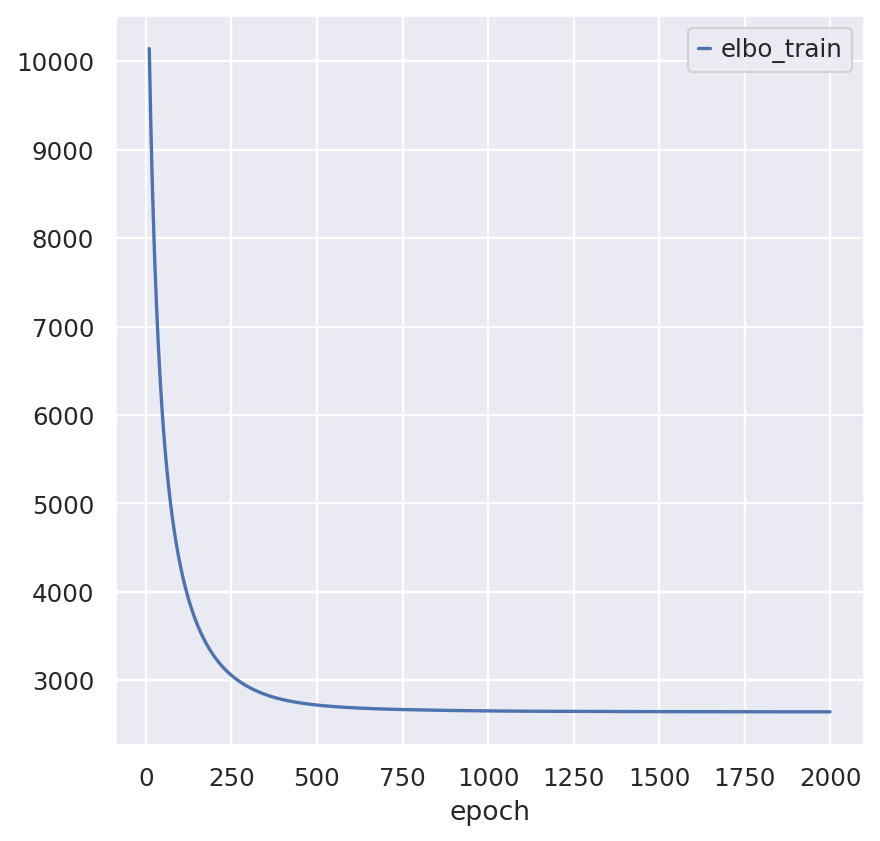

In [21]:
spatial_model_path = os.path.join(save_dir.name, "spatial_model")

spatial_model = SpatialStereoscope.from_rna_model(st_adata, sc_model)
spatial_model.train(max_epochs=2000)
spatial_model.history["elbo_train"][10:].plot()
spatial_model.save(spatial_model_path, overwrite=True)

## Deconvolution results

In [22]:
st_adata.obsm["deconvolution"] = spatial_model.get_proportions()

# also copy as single field in the anndata for visualization
for ct in st_adata.obsm["deconvolution"].columns:
    st_adata.obs[ct] = st_adata.obsm["deconvolution"][ct]

### Visualise populations

Et voilá, we have now an anndata object that contains the inferred proportions on each Visium spot for each cell type in our single cell reference dataset.

In this example we can observe how nicely the arterial endotehlial cells (EC5_art) and the venous endothelial cells (EC6_ven) are highlighted in the areas were we expect to see cardiac vessels based on the histology of the sample.

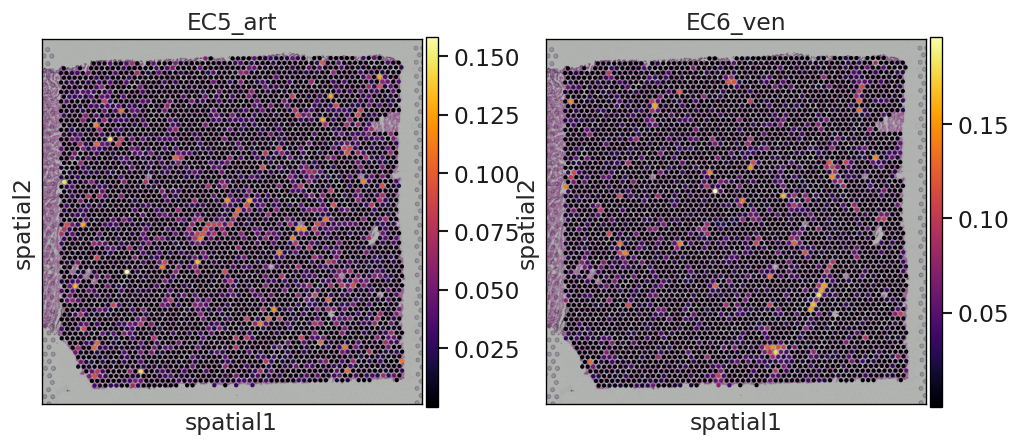

In [23]:
# low dpi for uploading to github
sc.settings.set_figure_params(
    dpi=60, color_map="RdPu", dpi_save=200, vector_friendly=True, format="svg"
)
sc.pl.spatial(
    st_adata,
    img_key="hires",
    color=["EC5_art", "EC6_ven"],
    size=1.2,
    color_map="inferno",
)